In [290]:
import numpy as np
from numpy import pi,sqrt
from qiskit import QuantumRegister, ClassicalRegister,QuantumCircuit, execute, IBMQ
from qiskit.circuit.library import MCMT, RZGate
from qiskit.tools.monitor import job_monitor
import qiskit.quantum_info as qi
'''Qiskit imports'''
from qiskit import(
    QuantumCircuit
    , execute
    , Aer
    , ClassicalRegister
    , QuantumRegister
)
backend_svec = Aer.get_backend('statevector_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')

from qiskit.visualization import plot_histogram

In [291]:
#Creating a customary unitary gate (tensored the V_k from article)

#kappa value which changes the unitary matrix
k = 2
#angle to be changed to np.arange once algorithm works
angle = 2

v = qi.Operator([[k/(k+1),-np.sqrt(k)/(k+1),-np.sqrt(k)/(k+1),1/(k+1)],
                [np.sqrt(k)/(k+1),k/(k+1),-1/(k+1),-np.sqrt(k)/(k+1)], 
                [np.sqrt(k)/(k+1),-1/(k+1),k/(k+1),-np.sqrt(k)/(k+1)],
                [1/(k+1),np.sqrt(k)/(k+1),np.sqrt(k)/(k+1),k/(k+1)]])

In [292]:
num_anc = 2
num_sys = 3

#define ancilla and system qubits
ancilla = QuantumRegister(num_anc,'|0\\rangle')
system = QuantumRegister(num_sys,'\psi')
#this is a classical bit to store the measurements
# ab = ClassicalRegister(num_anc,'ancilla_meas')
# sys_measure = ClassicalRegister(num_sys,'system_meas')

# intialize circuit for applying Rz gates
# phase = QuantumCircuit(ancilla,system)
# rz_gate = RZGate(angle)
# mcmt_gate = MCMT(rz_gate,num_anc,num_sys)
# phase.append(mcmt_gate,ancilla[:]+system[:])
# phase.draw('mpl')

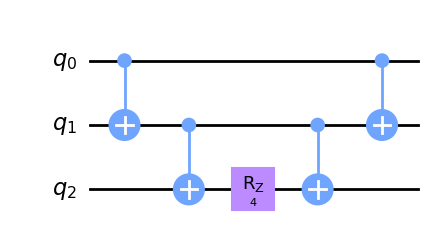

In [293]:
# #Creating a custom controlled gate for the unitary operator 
qc1 = QuantumCircuit(3,name='$e^{\lambda}$')
qc1.cx(0,1)
qc1.cx(1,2)
qc1.rz(2*angle,2)
qc1.cx(1,2)
qc1.cx(0,1)
unitary_ang = qc1.to_gate().control(2)

# 3\lambda
qc2 = QuantumCircuit(3,name='$e^{3\lambda}$')
qc2.cx(0,1)
qc2.cx(1,2)
qc2.rz(3*(2*angle),2)
qc2.cx(1,2)
qc2.cx(0,1)
unitary_ang3 = qc2.to_gate().control(2)

#conjugate: -3\lambda
qc3 = QuantumCircuit(3, name='$e^{-3\lambda}$')
qc3.cx(0,1)
qc3.cx(1,2)
qc3.rz(-3*(2*angle),2)
qc3.cx(1,2)
qc3.cx(0,1)
conjugate_1 = qc3.to_gate().control(2)

#conjugate: -\lambda
qc4 = QuantumCircuit(3,name='$e^{-\lambda}$')
qc4.cx(0,1)
qc4.cx(1,2)
qc4.rz(3*(2*angle),2)
qc4.cx(1,2)
qc4.cx(0,1)
conjugate_2 = qc4.to_gate().control(2)
qc1.draw('mpl')



In [294]:
#initializing the gate to create the zero-controlled gates using X-gates
prepare_x = QuantumCircuit(ancilla,system)
prepare_x.x(ancilla[0])
prepare_x.x(ancilla[1])
prepare_x.append(unitary_ang3,[0,1,2,3,4])
prepare_x.x(ancilla[0])
prepare_x.x(ancilla[1])

prepare_x2 = QuantumCircuit(ancilla,system)
prepare_x2.x(ancilla[1])
prepare_x2.append(conjugate_1,[0,1,2,3,4])
prepare_x2.x(ancilla[1])

#for second LCU for lambda angle
prepare_x1 = QuantumCircuit(ancilla,system)
prepare_x1.x(ancilla[0])
prepare_x1.append(unitary_ang,[0,1,2,3,4])
prepare_x1.x(ancilla[0])

prepare_x3 = QuantumCircuit(ancilla,system)
prepare_x3.append(conjugate_2,[0,1,2,3,4])




/Users/princetonwork/anaconda3/envs/pset_env/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


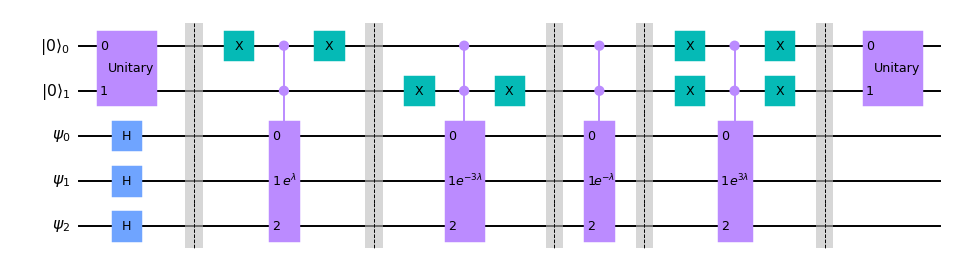

In [297]:
#composing unitary on ancilla circuit here
unit_circ = QuantumCircuit(ancilla,system)
unit_circ.unitary(v,[0,1])
#composing hadamards on system state
sys_hada_circ = QuantumCircuit(ancilla,system)
for i in range(num_sys):
    sys_hada_circ.h(system[i])
#composing circuit
main_circ = QuantumCircuit(ancilla,system)
main_circ = main_circ.compose(unit_circ)
main_circ = main_circ.compose(sys_hada_circ)
main_circ.barrier()

#implementing LCU algorithm
main_circ = main_circ.compose(prepare_x1)
main_circ.barrier()
#
main_circ = main_circ.compose(prepare_x2)
main_circ.barrier()
#
main_circ = main_circ.compose(prepare_x3)
main_circ.barrier()
#
main_circ = main_circ.compose(prepare_x)
main_circ.barrier()

#applying inverse unitary to ancilla qubits
inverse = v.conjugate()
inv_circ = QuantumCircuit(ancilla,system)
inv_circ.unitary(inverse,[0,1])
main_circ = main_circ.compose(inv_circ)


main_circ.draw('mpl', scale=0.7)




In [296]:
sv = Statevector.from_label('00000')
sv = sv.evolve(main_circ)
sv.data

array([ 0.14585274+0.14827649j,  0.18314765+0.03499344j,
       -0.04623854-0.06998688j,  0.19361872-0.0494882j ,
        0.14585274-0.14827649j,  0.18314765-0.03499344j,
       -0.04623854+0.06998688j,  0.19361872+0.0494882j ,
        0.14585274-0.14827649j,  0.18314765-0.03499344j,
       -0.04623854+0.06998688j,  0.19361872+0.0494882j ,
        0.14585274+0.14827649j,  0.18314765+0.03499344j,
       -0.04623854-0.06998688j,  0.19361872-0.0494882j ,
        0.14585274-0.14827649j,  0.18314765-0.03499344j,
       -0.04623854+0.06998688j,  0.19361872+0.0494882j ,
        0.14585274+0.14827649j,  0.18314765+0.03499344j,
       -0.04623854-0.06998688j,  0.19361872-0.0494882j ,
        0.14585274+0.14827649j,  0.18314765+0.03499344j,
       -0.04623854-0.06998688j,  0.19361872-0.0494882j ,
        0.14585274-0.14827649j,  0.18314765-0.03499344j,
       -0.04623854+0.06998688j,  0.19361872+0.0494882j ])